In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix

from utils import Pyutils as pyutils

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

SOURCE_PATH = os.getcwd()
INPUTS_PATH = os.path.join(SOURCE_PATH, "data", "inputs")
OUTPUTS_PATH = os.path.join(SOURCE_PATH, "data", "outputs")
DATASET_NAMES = ["betadgp_covdgp_data", "betadgp_beta2x2_data", "betadgp_data"]
TARGET_NAME = "betas_dgp"
MODEL_TAGS = ["linear_reg", "ffnn"]
ROC_THRESHOLD = 0

## 1) Aggregate all results

In [2]:
mini_output_report = []
all_data = []
model_summary = []
class_data = []
cm_data = []
roc = []
idx = 0
for model_tag in tqdm(MODEL_TAGS,
                      desc="Append all model results"):
    
    DGPS = os.listdir(os.path.join(OUTPUTS_PATH, model_tag))
    for dgp_name in DGPS:
        for ds in DATASET_NAMES:
            
            
            try:
                check1 = pd.read_csv(os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_result.csv"))
                check2 = pyutils.load_pkl(path=os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_model.pickle"))
            except:
                mini_output_report.append(pd.DataFrame([{"model": model_tag, "dgp": dgp_name, "dataset": ds}]))
                continue
            
            data = check1
            data["model"] = model_tag
            data["dgp"] = dgp_name
            data["dataset"] = ds
            
            # distance metrics
            mse = mean_squared_error(y_true=data["y"],
                                     y_pred=data["pred"])
            mae = mean_absolute_error(y_true=data["y"],
                                      y_pred=data["pred"])

            model_summary_tmp = check2
            model_summary_tmp["model"] = model_tag
            model_summary_tmp["dgp"] = dgp_name
            model_summary_tmp["number_of_variables"] = int(model_summary_tmp['dgp'].split("_")[1])
            model_summary_tmp["dataset"] = ds
            model_summary_tmp["mse"] = mse
            model_summary_tmp["mae"] = mae
            if model_tag == "linear_reg":
                model_summary_tmp['coef'] = str(tuple(map(tuple, model_summary_tmp['coef']))[0])
            
            model_summary.append(pd.DataFrame(model_summary_tmp,
                                              index=[idx]))
            
            tmp_class_data = pd.DataFrame({"y_class": np.where(data["y"] > ROC_THRESHOLD, 1, 0),
                                           "pred_class": np.where(data["pred"] > ROC_THRESHOLD, 1, 0),
                                           "y": data["y"],
                                           "pred": data["pred"],
                                           "model": model_tag,
                                           "dgp": dgp_name,
                                           "dataset": ds})
            class_data.append(tmp_class_data)
            
            # confusion matrix            
            tmp_confusion_matrix = pd.DataFrame(confusion_matrix(tmp_class_data['y_class'],
                                                                 tmp_class_data['pred_class']))
            tmp_confusion_matrix.index.name = "Actual"
            tmp_confusion_matrix.columns.name = "Predicted"
                                          
            tmp_confusion_matrix = (tmp_confusion_matrix / tmp_confusion_matrix.sum().sum()) * 100
            melt_tmp_confusion_matrix = tmp_confusion_matrix.reset_index()
            melt_tmp_confusion_matrix = melt_tmp_confusion_matrix.melt("Actual")
            melt_tmp_confusion_matrix["model"] = model_tag
            melt_tmp_confusion_matrix["dgp"] = dgp_name
            melt_tmp_confusion_matrix["dataset"] = ds
            melt_tmp_confusion_matrix["number_of_variables"] = int(model_summary_tmp['dgp'].split("_")[1])
            
            cm_data.append(melt_tmp_confusion_matrix)
            
            tmp_roc = pyutils.roc_from_scratch(y_pred=data["pred"],
                                               y_true=np.where(data["y"] > 0, 1, 0),
                                               partitions=50)
            tmp_roc_df = pd.DataFrame(tmp_roc, columns=["FP", "TP"])
            tmp_roc_df["model"] = model_tag
            tmp_roc_df["dgp"] = dgp_name
            tmp_roc_df["dataset"] = ds
            tmp_roc_df["number_of_variables"] = int(model_summary_tmp['dgp'].split("_")[1])
            
            roc.append(tmp_roc_df)
            
            idx += 1
            
            all_data.append(data)
            
all_data_df = pd.concat(all_data, axis=0)
model_summary_df = pd.concat(model_summary, axis=0)
class_data_df = pd.concat(class_data, axis=0)
cm_data_df = pd.concat(cm_data, axis=0).reset_index(drop=True)
roc_df = pd.concat(roc, axis=0)

Append all model results: 100%|██████████| 2/2 [03:33<00:00, 106.94s/it]


## 2) Compute relevant metrics

> a) Mean squared error

> b) Mean absolute error

In [3]:
metrics_df = all_data_df.drop(["Var1", "Var2"], axis=1)
mse_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(pyutils.mse_melt).reset_index()
mae_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(pyutils.mae_melt).reset_index()

### MSE histogram

Text(0.5, 1.0, 'MSE of the OOS forecast for each test simulation')

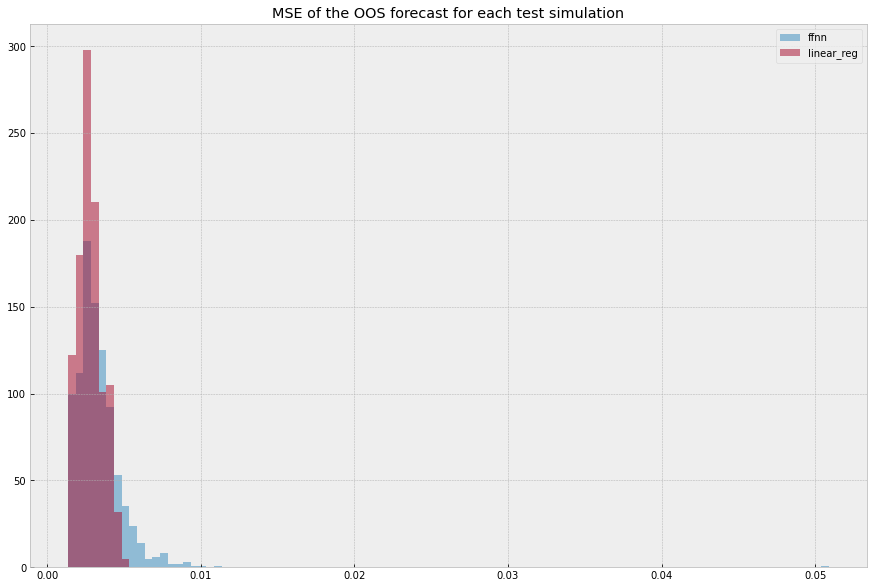

In [4]:
ffnn_hist_mse = mse_group_df.loc[mse_group_df["model"]=="ffnn"][["mse"]]
ffnn_hist_mse.rename(columns={"mse": "ffnn mse"}, inplace=True)

ffnn_wmse_hist_mse = mse_group_df.loc[mse_group_df["model"]=="ffnn_wmse"][["mse"]]
ffnn_wmse_hist_mse.rename(columns={"mse": "ffnn_wmse mse"}, inplace=True)

linear_reg_hist_mse = mse_group_df.loc[mse_group_df["model"]=="linear_reg"][["mse"]]
linear_reg_hist_mse.rename(columns={"mse": "linear_reg mse"}, inplace=True)

hist_mse_df = pd.concat([ffnn_hist_mse.reset_index(drop=True), linear_reg_hist_mse.reset_index(drop=True)], axis=1)

bins = np.linspace(hist_mse_df.min().min(), hist_mse_df.max().max(), 100)
plt.hist(hist_mse_df[hist_mse_df.columns[0]], bins, alpha=0.5, label='ffnn')
plt.hist(hist_mse_df[hist_mse_df.columns[1]], bins, alpha=0.5, label='linear_reg')
plt.legend(loc='upper right')
plt.title("MSE of the OOS forecast for each test simulation")

### MAE histogram

Text(0.5, 1.0, 'MAE of the OOS forecast for each test simulation')

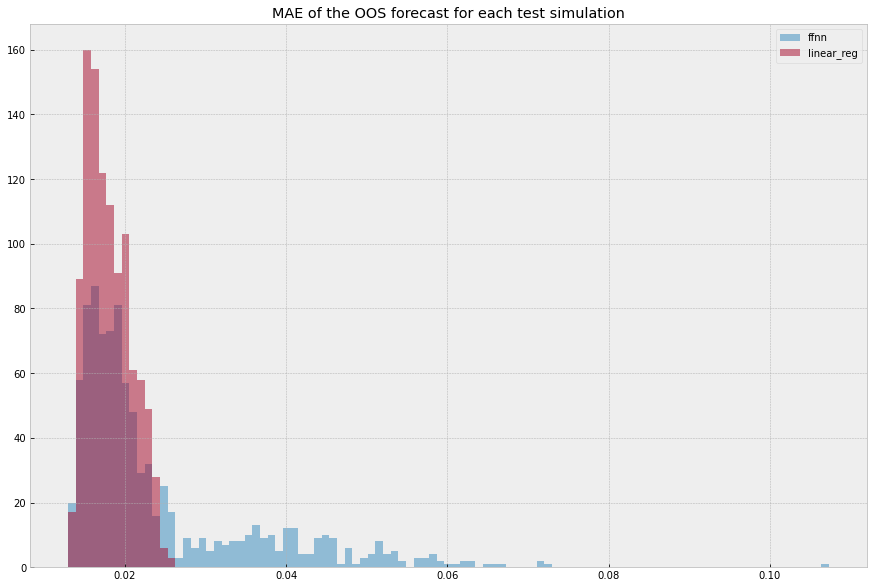

In [5]:
ffnn_hist_mae = mae_group_df.loc[mae_group_df["model"]=="ffnn"][["mae"]]
ffnn_hist_mae.rename(columns={"mae": "ffnn mae"}, inplace=True)

linear_reg_hist_mae = mae_group_df.loc[mae_group_df["model"]=="linear_reg"][["mae"]]
linear_reg_hist_mae.rename(columns={"mae": "linear_reg mae"}, inplace=True)

hist_mae_df = pd.concat([ffnn_hist_mae.reset_index(drop=True), linear_reg_hist_mae.reset_index(drop=True)], axis=1)

bins = np.linspace(hist_mae_df.min().min(), hist_mae_df.max().max(), 100)
plt.hist(hist_mae_df[hist_mae_df.columns[0]], bins, alpha=0.5, label='ffnn')
plt.hist(hist_mae_df[hist_mae_df.columns[1]], bins, alpha=0.5, label='linear_reg')
plt.legend(loc='upper right')
plt.title("MAE of the OOS forecast for each test simulation")

## 3) Analysis of the chosen FFNN architectures

### Distribution of the number of hidden units and neurons per unit

In [6]:
ffnn_summary_df = model_summary_df.loc[model_summary_df['model'] == "ffnn"]
linear_reg_summary_df = model_summary_df.loc[model_summary_df['model'] == "linear_reg"]

Text(0.5, 1.0, 'Distribution of the number of hidden units in each chosen ffnn')

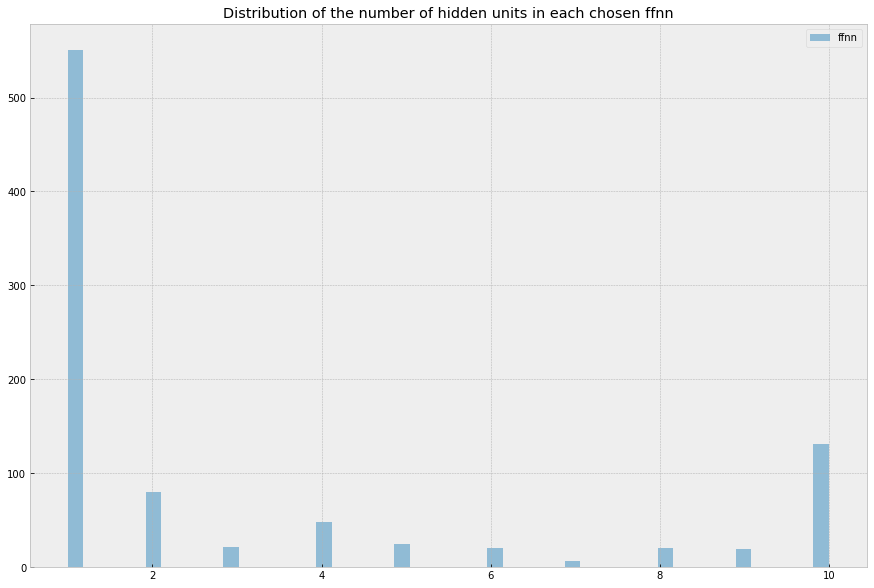

In [7]:
bins = np.linspace(ffnn_summary_df['n_hidden'].min(), ffnn_summary_df['n_hidden'].max(), 50)
plt.hist(ffnn_summary_df['n_hidden'], bins, alpha=0.5, label='ffnn')
plt.legend(loc='upper right')
plt.title("Distribution of the number of hidden units in each chosen ffnn")

Text(0.5, 1.0, 'Distribution of the number of neurons per hidden units in each chosen ffnn')

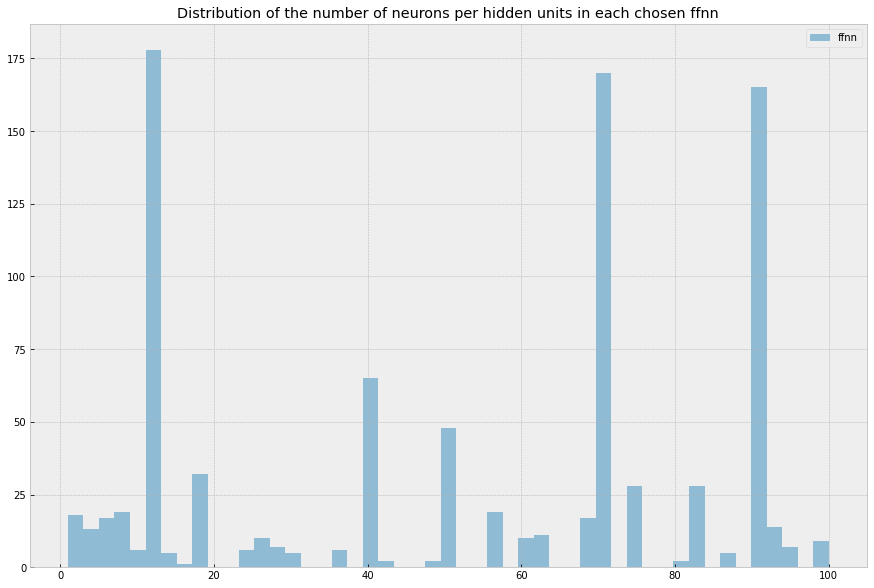

In [8]:
bins = np.linspace(ffnn_summary_df['n_neurons'].min(), ffnn_summary_df['n_neurons'].max(), 50)
plt.hist(ffnn_summary_df['n_neurons'], bins, alpha=0.5, label='ffnn')
plt.legend(loc='upper right')
plt.title("Distribution of the number of neurons per hidden units in each chosen ffnn")

### Analysis of the parameters of the best ffnn architectures

In [9]:
ffnn_summary_df.sort_values("mse", ascending=True).head(10).dropna(axis=1)

,model,dgp,number_of_variables,dataset,mse,mae,activation,input_shape,learning_rate,n_hidden,n_neurons
1767,ffnn,ar1_495_random,495,betadgp_covdgp_data,0.001371,0.014052,relu,1.0,0.020633,2.0,40.0
1779,ffnn,ar1_499_random,499,betadgp_covdgp_data,0.001418,0.012976,relu,1.0,0.000673,2.0,50.0
1371,ffnn,ar1_494_random,494,betadgp_covdgp_data,0.001463,0.013617,relu,1.0,0.000824,2.0,40.0
1068,ffnn,ar1_492_random,492,betadgp_covdgp_data,0.001466,0.013770,relu,1.0,0.000692,8.0,7.0
1632,ffnn,ar1_483_random,483,betadgp_covdgp_data,0.001474,0.012916,relu,1.0,0.022396,1.0,70.0
1200,ffnn,ar1_455_random,455,betadgp_covdgp_data,0.001477,0.015342,relu,1.0,0.022842,1.0,90.0
1377,ffnn,ar1_498_random,498,betadgp_covdgp_data,0.001485,0.014301,relu,1.0,0.022842,1.0,90.0
1608,ffnn,ar1_481_random,481,betadgp_covdgp_data,0.001500,0.013923,relu,1.0,0.022842,1.0,90.0
1404,ffnn,ar1_496_random,496,betadgp_covdgp_data,0.001508,0.013809,relu,1.0,0.000309,10.0,82.0
1831,ffnn,ar1_474_random,474,betadgp_covdgp_data,0.001509,0.014891,relu,1.0,0.022842,1.0,90.0


In [10]:
ffnn_summary_df.sort_values("mse", ascending=True).tail(10).dropna(axis=1)

,model,dgp,number_of_variables,dataset,mse,mae,activation,input_shape,learning_rate,loss,n_hidden,n_neurons
1433,ffnn,ar1_183_random,183,betadgp_data,0.008125,0.061968,relu,2.0,0.000574,mse,1.0,13.0
1640,ffnn,ar1_177_random,177,betadgp_data,0.008454,0.066727,relu,2.0,0.000564,mse,1.0,19.0
1643,ffnn,ar1_169_random,169,betadgp_data,0.008577,0.062761,relu,2.0,0.000574,mse,1.0,13.0
1169,ffnn,ar1_230_random,230,betadgp_data,0.008873,0.064475,relu,2.0,0.000574,mse,1.0,13.0
1241,ffnn,ar1_197_random,197,betadgp_data,0.009053,0.066077,relu,2.0,0.000574,mse,1.0,13.0
1935,ffnn,ar1_415_random,415,betadgp_data,0.009339,0.071414,relu,2.0,0.000574,mse,1.0,13.0
1929,ffnn,ar1_190_random,190,betadgp_data,0.009541,0.072687,relu,2.0,0.000574,mse,1.0,13.0
1547,ffnn,ar1_403_random,403,betadgp_data,0.010016,0.071743,relu,2.0,0.000564,mse,1.0,19.0
1546,ffnn,ar1_403_random,403,betadgp_beta2x2_data,0.010902,0.048070,relu,1.0,0.022396,mse,1.0,70.0
1192,ffnn,ar1_308_random,308,betadgp_beta2x2_data,0.050887,0.107297,relu,1.0,0.022396,mse,1.0,70.0


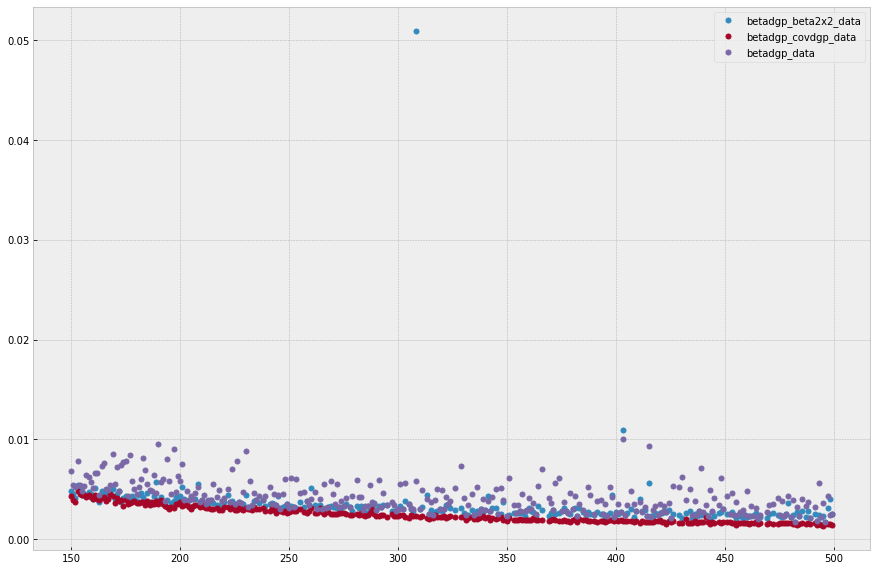

In [12]:
ffnn_achitectures_df = model_summary_df.loc[model_summary_df["model"] == "ffnn"]
groups = ffnn_achitectures_df.groupby("dataset")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group["number_of_variables"],
            group["mse"],
            marker='o',
            linestyle='',
            ms=5,
            label=name)
ax.legend()

### Analysis of the parameters of the best linear_reg

In [13]:
linear_reg_summary_df.sort_values("mse", ascending=True).head(10).dropna(axis=1)

,coef,model,dgp,number_of_variables,dataset,mse,mae
813,"(0.0005767225015363976,)",linear_reg,ar1_495_random,495,betadgp_covdgp_data,0.001352,0.013217
825,"(0.001315320155226175,)",linear_reg,ar1_499_random,499,betadgp_covdgp_data,0.001417,0.013262
174,"(0.001155887781277533,)",linear_reg,ar1_455_random,455,betadgp_covdgp_data,0.001442,0.013639
207,"(0.0014147554565225554,)",linear_reg,ar1_500_random,500,betadgp_covdgp_data,0.001446,0.013456
666,"(0.0011444539093500425,)",linear_reg,ar1_483_random,483,betadgp_covdgp_data,0.001461,0.013565
369,"(0.0005596964472279746,)",linear_reg,ar1_494_random,494,betadgp_covdgp_data,0.001462,0.013590
21,"(0.0009960862168031416,)",linear_reg,ar1_492_random,492,betadgp_covdgp_data,0.001466,0.013602
375,"(0.0009239691082873969,)",linear_reg,ar1_498_random,498,betadgp_covdgp_data,0.001471,0.013704
639,"(0.0014672787155626166,)",linear_reg,ar1_481_random,481,betadgp_covdgp_data,0.001499,0.013593
531,"(0.0010878798159725997,)",linear_reg,ar1_472_random,472,betadgp_covdgp_data,0.001500,0.013750


In [14]:
linear_reg_summary_df.sort_values("mse", ascending=True).tail(10).dropna(axis=1)

,coef,model,dgp,number_of_variables,dataset,mse,mae
259,"(-0.0005886227255515065,)",linear_reg,ar1_164_random,164,betadgp_beta2x2_data,0.004726,0.023990
260,"(-0.0003729494357476584, -0.0011198670493357493)",linear_reg,ar1_164_random,164,betadgp_data,0.004727,0.024048
664,"(0.0008535891715881661,)",linear_reg,ar1_165_random,165,betadgp_beta2x2_data,0.004815,0.024258
665,"(-0.0005567561271513988, 0.0022853709312425996)",linear_reg,ar1_165_random,165,betadgp_data,0.004816,0.024385
1,"(-4.871893774449197e-05,)",linear_reg,ar1_150_random,150,betadgp_beta2x2_data,0.004845,0.024207
800,"(0.0024751383299643007, 0.0006289150032002763)",linear_reg,ar1_157_random,157,betadgp_data,0.004859,0.023629
799,"(0.0031863867166131267,)",linear_reg,ar1_157_random,157,betadgp_beta2x2_data,0.004865,0.024591
2,"(-0.0026842849049166606, -0.001154914322603748)",linear_reg,ar1_150_random,150,betadgp_data,0.004888,0.023796
379,"(-0.0008489041017990626,)",linear_reg,ar1_160_random,160,betadgp_beta2x2_data,0.004979,0.024020
380,"(-0.0018077446114485674, 0.002207722255778325)",linear_reg,ar1_160_random,160,betadgp_data,0.004988,0.023939


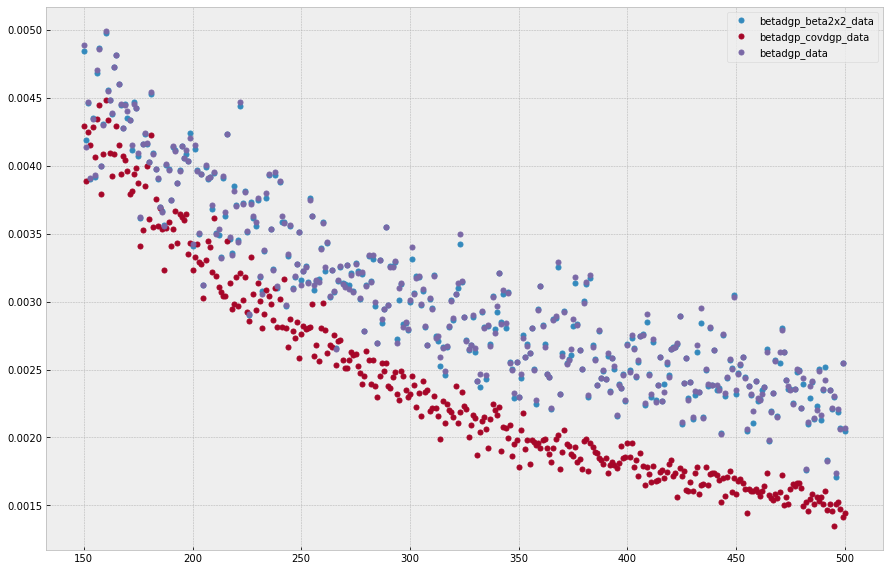

In [15]:
groups = linear_reg_summary_df.groupby("dataset")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group["number_of_variables"],
            group["mse"],
            marker='o',
            linestyle='',
            ms=5,
            label=name)
ax.legend()

### Scatter plot for the true beta (y) as a function of the predicted values (x) for the best models

In [16]:
best_ffnn_df = all_data_df.loc[(all_data_df["dgp"] == "ar1_150_random")&
                               (all_data_df["dataset"] == "betadgp_data")&
                               (all_data_df["model"] == "ffnn")]
best_linear_reg_df = all_data_df.loc[(all_data_df["dgp"] == "ar1_150_random")&
                                     (all_data_df["dataset"] == "betadgp_data")&
                                     (all_data_df["model"] == "linear_reg")]

Text(0.5, 1.0, 'Distribution of the true VAR betas')

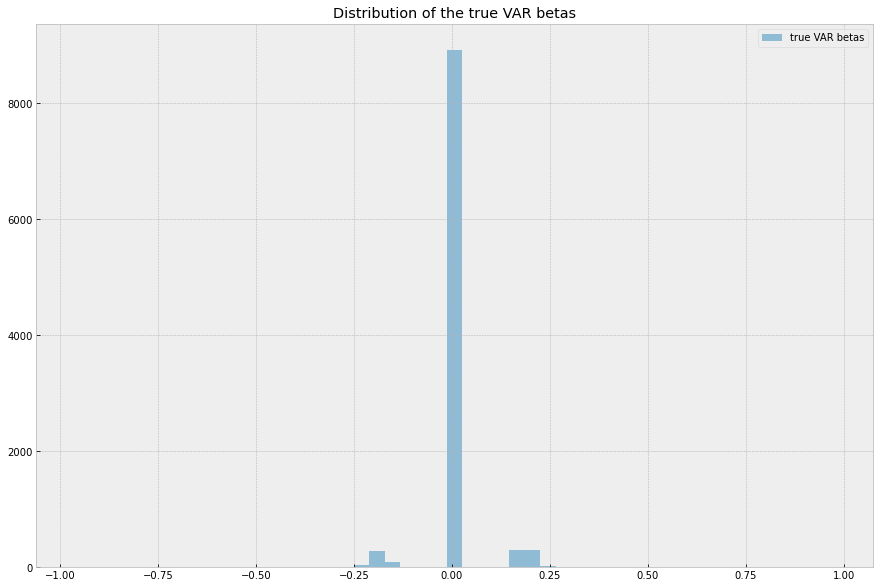

In [17]:
bins = np.linspace(best_linear_reg_df['y'].min(), best_linear_reg_df['y'].max(), 50)
plt.hist(best_linear_reg_df['y'], bins, alpha=0.5, label='true VAR betas')
plt.legend(loc='upper right')
plt.title("Distribution of the true VAR betas")

#### FFNN

<AxesSubplot:title={'center':'FFNN model'}, xlabel='pred', ylabel='y'>

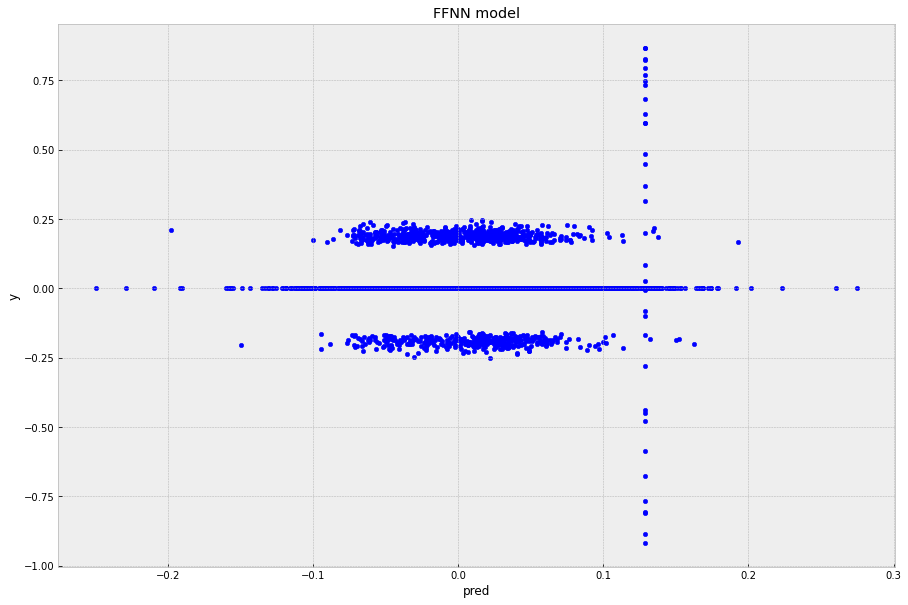

In [18]:
best_ffnn_df.plot.scatter(y="y", x="pred", title="FFNN model")

#### Linear regression

<AxesSubplot:title={'center':'linear regression model'}, xlabel='pred', ylabel='y'>

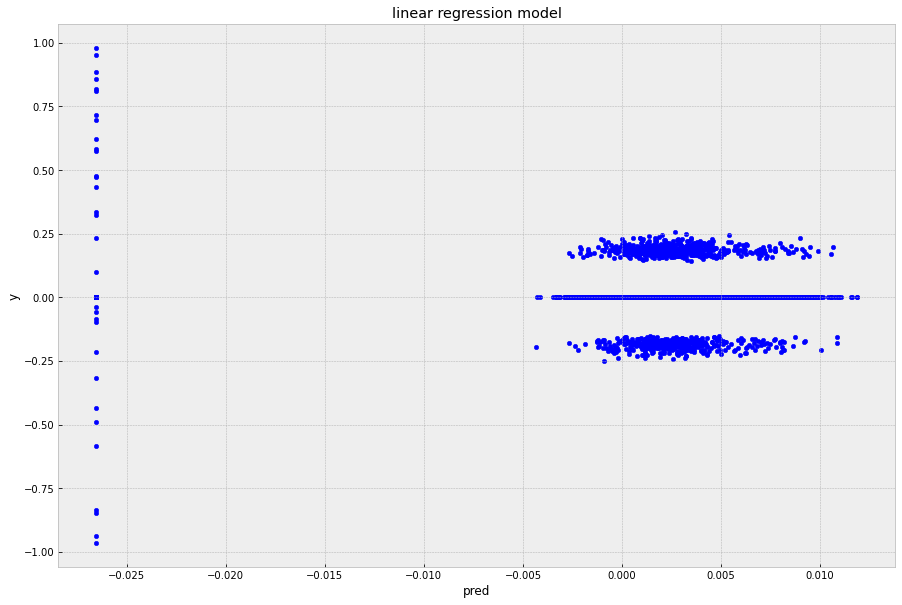

In [19]:
best_linear_reg_df.plot.scatter(y="y", x="pred", title="linear regression model")

### Confusion matrixclass_data_df

In [20]:
linear_reg_cm_data_df = cm_data_df.loc[cm_data_df["model"] == "linear_reg"]
ffnn_cm_data_df = cm_data_df.loc[cm_data_df["model"] == "ffnn"]

In [21]:
e1e2_linear_reg_cm_data_df = linear_reg_cm_data_df.loc[((linear_reg_cm_data_df["Actual"] == 0)&(linear_reg_cm_data_df["Predicted"] == 1))|
                                                       ((linear_reg_cm_data_df["Actual"] == 1)&(linear_reg_cm_data_df["Predicted"] == 0))]
e1e2_linear_reg_cm_data_df.loc[:,"error_type"] = np.where((e1e2_linear_reg_cm_data_df["Actual"]==0)&(e1e2_linear_reg_cm_data_df["Predicted"]==1),
                                                          "FP",
                                                          "FN")

e1e2_ffnn_cm_data_df = ffnn_cm_data_df.loc[((ffnn_cm_data_df["Actual"] == 0)&(ffnn_cm_data_df["Predicted"] == 1))|
                                           ((ffnn_cm_data_df["Actual"] == 1)&(ffnn_cm_data_df["Predicted"] == 0))]
e1e2_ffnn_cm_data_df.loc[:,"error_type"] = np.where((e1e2_ffnn_cm_data_df["Actual"]==0)&(e1e2_ffnn_cm_data_df["Predicted"]==1),
                                                    "FP",
                                                    "FN")


/Users/danieloliveira/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/danieloliveira/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/danieloliveira/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 

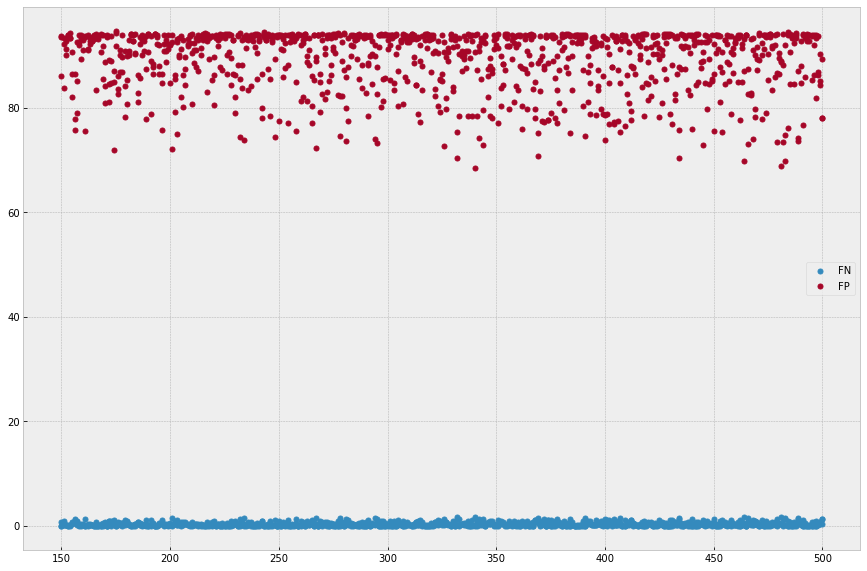

In [22]:
groups = e1e2_linear_reg_cm_data_df.groupby("error_type")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group["number_of_variables"],
            group["value"],
            marker='o',
            linestyle='',
            ms=5,
            label=name)
ax.legend()

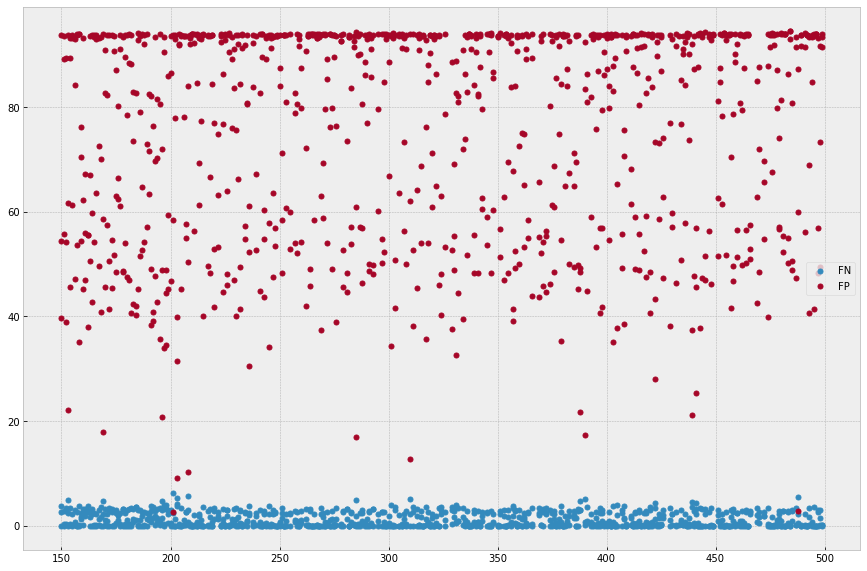

In [23]:
groups = e1e2_ffnn_cm_data_df.groupby("error_type")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group["number_of_variables"],
            group["value"],
            marker='o',
            linestyle='',
            ms=5,
            label=name)
ax.legend()

### ROC curves

Text(0.5, 0, 'FP')

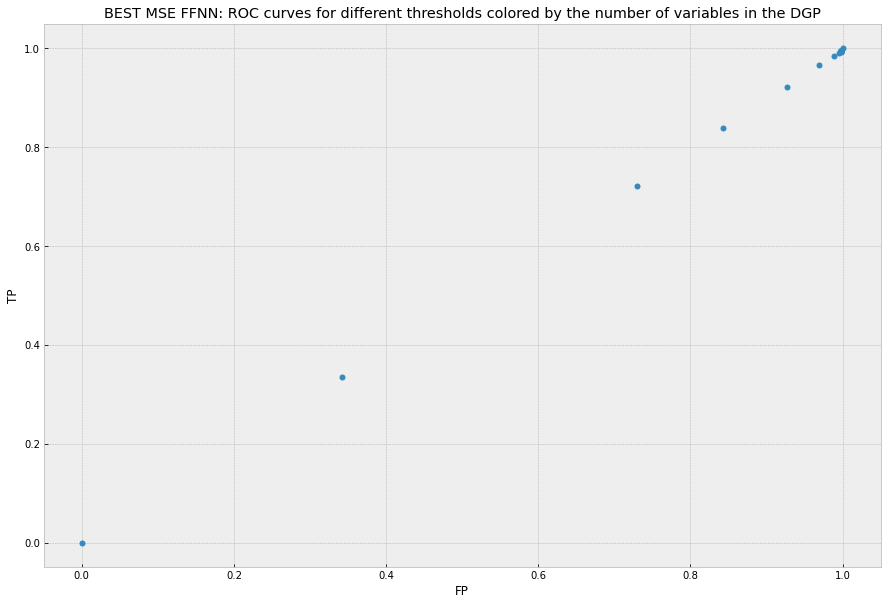

In [45]:
groups = roc_df.loc[(roc_df["model"] == "ffnn")&
                    (roc_df["dgp"] == "ar1_495_random")&
                    (roc_df["number_of_variables"] == 495)&
                    (roc_df["dataset"] == "betadgp_covdgp_data")].groupby("number_of_variables")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group["FP"],
            group["TP"],
            marker='o',
            linestyle='',
            ms=5,
            label=name)
ax.set_title("BEST MSE FFNN: ROC curves for different thresholds colored by the number of variables in the DGP")
ax.set_ylabel("TP")
ax.set_xlabel("FP")

Text(0.5, 0, 'FP')

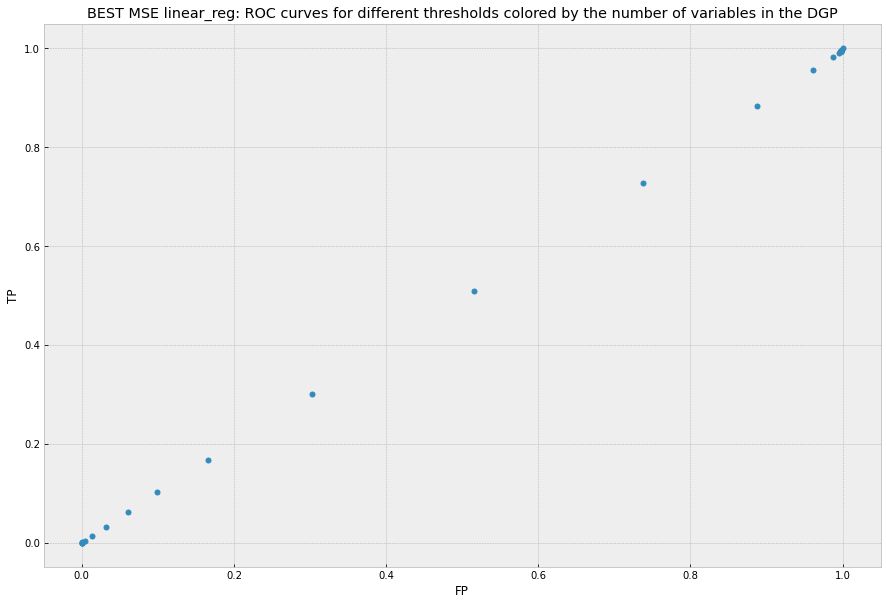

In [46]:
groups = roc_df.loc[(roc_df["model"] == "linear_reg")&
                    (roc_df["dgp"] == "ar1_495_random")&
                    (roc_df["number_of_variables"] == 495)&
                    (roc_df["dataset"] == "betadgp_covdgp_data")].groupby("number_of_variables")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group["FP"],
            group["TP"],
            marker='o',
            linestyle='',
            ms=5,
            label=name)
ax.set_title("BEST MSE linear_reg: ROC curves for different thresholds colored by the number of variables in the DGP")
ax.set_ylabel("TP")
ax.set_xlabel("FP")

Text(0.5, 0, 'FP')

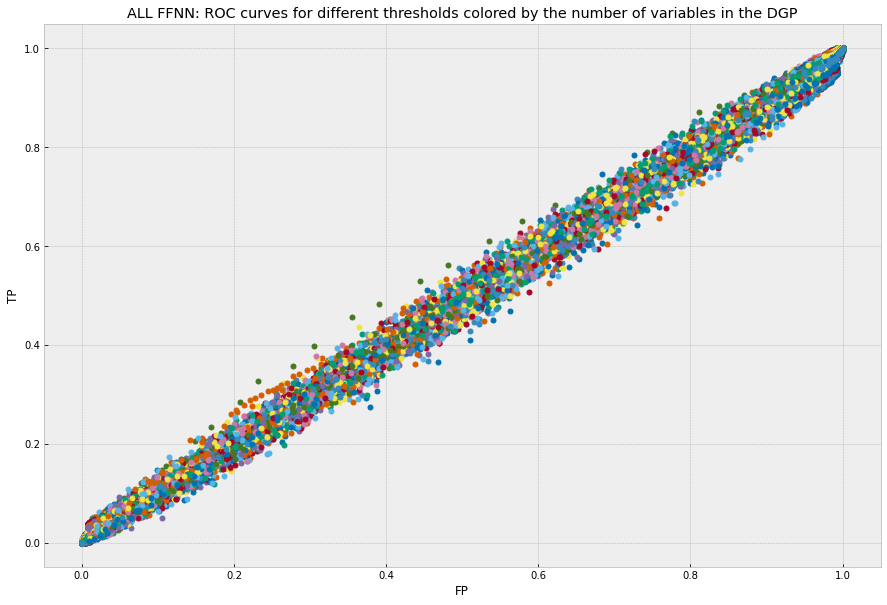

In [47]:
mean_roc_df = roc_df.loc[(roc_df["model"] == "ffnn")].groupby(["model", "dgp", "dataset", "number_of_variables"]).mean().reset_index()
groups = roc_df.groupby("number_of_variables")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group["FP"],
            group["TP"],
            marker='o',
            linestyle='',
            ms=5,
            label=name)
ax.set_title("ALL FFNN: ROC curves for different thresholds colored by the number of variables in the DGP")
ax.set_ylabel("TP")
ax.set_xlabel("FP")

Text(0.5, 0, 'FP')

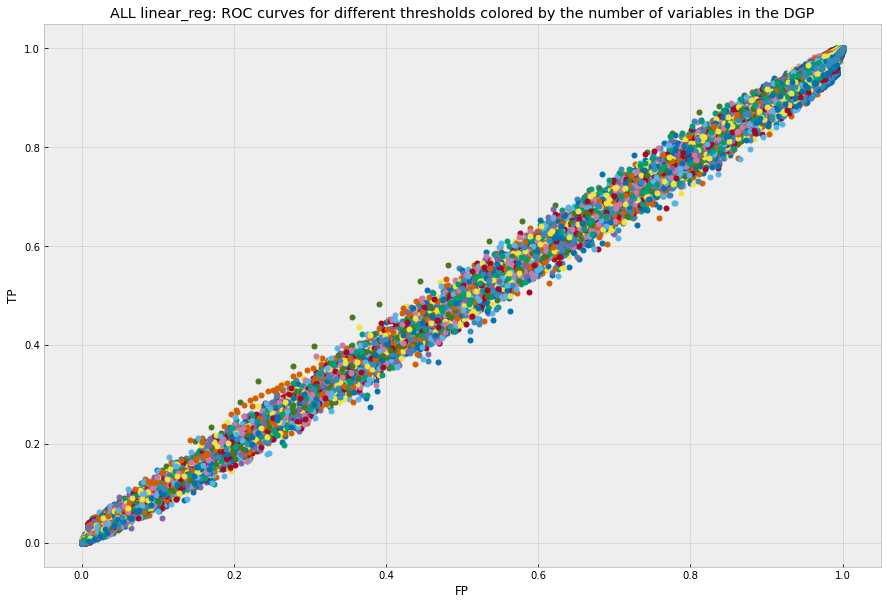

In [48]:
mean_roc_df = roc_df.loc[(roc_df["model"] == "linear_reg")].groupby(["model", "dgp", "dataset", "number_of_variables"]).mean().reset_index()
groups = roc_df.groupby("number_of_variables")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group["FP"],
            group["TP"],
            marker='o',
            linestyle='',
            ms=5,
            label=name)
ax.set_title("ALL linear_reg: ROC curves for different thresholds colored by the number of variables in the DGP")
ax.set_ylabel("TP")
ax.set_xlabel("FP")